# Project 1
### Jacob Hofer, Flint Morgan, Joseph Winjum, Keith Filler
---
ct 1

Part 1: Thinking about the data

1.1	As Computer Science, Electrical, and Computer Engineering graduate students, this data set studying transistor scaling in CPUs and GPUs directly relates to each of our academic backgrounds. We all possess a good foundation of knowledge to be able to obtain relevant information from this study. 
1.2	We have a total of ten attributes in this data set. If we consider “release date” to be a numerical attribute of the data set, then we have 6 numerical attributes. We then have four categorical attributes.
1.3	 Yes, our data set has missing values. Our approach is to simply remove all data instances with missing values. Our initial data set contains over 4,800 entries. After removing the rows with missing data, we are left with 3,422 data instances. This is still a substantial data set to complete our project and obtain meaningful data. 
1.4	For this data set we expect the numerical attributes related to the physical structure of the CPU, GPU and underlying transistors to be the most descriptive. The knowledge to be gained from studying this data lies in the functionality of the various CPUs and GPUs. Some key findings from the original study of this data set include: 
•	Moore’s law still holds as of the time of the initial study in July 2020
•	Dennard scaling is still valid.
•	CPUs have higher frequencies, but GPUs are catching up.
These findings represent a few from the initial study performed on this data set by 
Sun, Yifan et al [1]. These findings, and others, were determined from studying the numerical attributesf theta set.


1.5	   We expect clusters to be present in the data because we are studying features of physical components that have similar traits. The data set is looking at slight changes in manufacture and performance for electronic components. While the distinction between clusters may not be entirely clear initially, there will be some distinct, numerical, dividing lines among these differences.
1.6	Finding clusters may be helpful in studying these differences in the physical design of components and seeing the effect these features have on the performance of the CPUs and GPUs. While it may be unclear to see a recognizable pattern from simply looking at plotted data values, clustering may offer some further insight into the connection between physical attributes nd performance.
1.7 	Initially we would expect to see at least two clusters, if the data was clustered into characteristics for CPU and GPU. Perhaps we would see up to 4 clusters if these two distinctions were , but the most likely expectation is for two clustershen  The initial data set has approximately the same amount of data entries for CPU and GPU, so we anticipate similar size clusters. Depending how many null values we remove from each attribute this result may vary. ..)? Why or why not?  




Works Cited
1.	Sun, Yifan et al. “Summarizing CPU and GPU Design Trends with P
ct Data”, July 13, 2020.





---
## Loading data
Below is the code to load our data from the CSV into a Pandas DataFrame

We are dropping the columns including semantic data, such as the product name, since we do not want to attempt to cluster based on those columns.

We also drop the GFLOPS columns, as those are specific to GPUs, and we want to include both GPUs and CPUs.

Lastly, we drop any rows that have missing data. 

We can't fill the empty values with the mean for the column because as the die size, transistors and frequency will increase quickly with year, and if we choose to put the mean it could miss represent the data.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("chip_dataset.csv")

Type = df['Type']
# Drop semantic data
df.pop("Unnamed: 0");df.pop("Type");df.pop("Foundry");df.pop("Vendor");df.pop("Product");df.pop("Release Date")
# GFLOPS are specific to GPUs, so we exclude them here so we can also look at CPUs
df.pop("FP16 GFLOPS");df.pop("FP32 GFLOPS");df.pop("FP64 GFLOPS")
df = df.dropna()
display(df)


,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz)
0,65.0,45.0,77.0,122.0,2200.0
1,14.0,35.0,192.0,4800.0,3200.0
3,22.0,80.0,160.0,1400.0,1800.0
4,45.0,125.0,258.0,758.0,3700.0
5,22.0,95.0,160.0,1400.0,2400.0
...,...,...,...,...,...
4844,40.0,150.0,334.0,2154.0,700.0
4845,40.0,20.0,80.0,10.0,416.0
4846,28.0,21.0,68.0,302.0,550.0
4849,40.0,75.0,332.0,1950.0,450.0


## Part 2
---
### 2.1 What is the multivariate mean of the numerical data matrix (where categorical data have been converted to numerical values)?

In [53]:
multivariate_mean = np.mean(df, axis=0)
print(multivariate_mean)

Process Size (nm)          53.048510
TDP (W)                    83.740795
Die Size (mm^2)           200.003799
Transistors (million)    2163.295441
Freq (MHz)               1507.964641
dtype: float64


### 2.2 What is the covariance matrix of the numerical data matrix (where categorical data have been converted to numerical values)?

In [54]:
np.cov(df.T),4

(array([[ 1.69299735e+03, -6.30190287e+02, -1.20099872e+03,
         -7.07678799e+04, -4.15324090e+03],
        [-6.30190287e+02,  6.19103861e+03,  6.98827839e+03,
          1.59811097e+05,  5.04068449e+03],
        [-1.20099872e+03,  6.98827839e+03,  1.71075145e+04,
          3.62122130e+05, -7.33121939e+03],
        [-7.07678799e+04,  1.59811097e+05,  3.62122130e+05,
          1.86984633e+07, -1.93198269e+05],
        [-4.15324090e+03,  5.04068449e+03, -7.33121939e+03,
         -1.93198269e+05,  1.02569738e+06]]),
 4)

### 2.3 Choose 2 pairs of attributes that you think could be related. Create scatter plots of all 2 pairs and include these in your report, along with a description and analysis that summarizes why these pairs of attributes might be related, and how the scatter plots do or do not support this intuition.

We believe that die size and transistors will be related because as the die size increases the total number of transistors could increase given the same size of transistor.

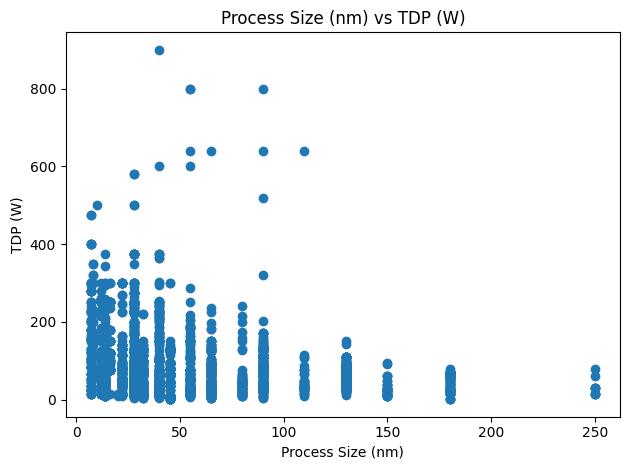

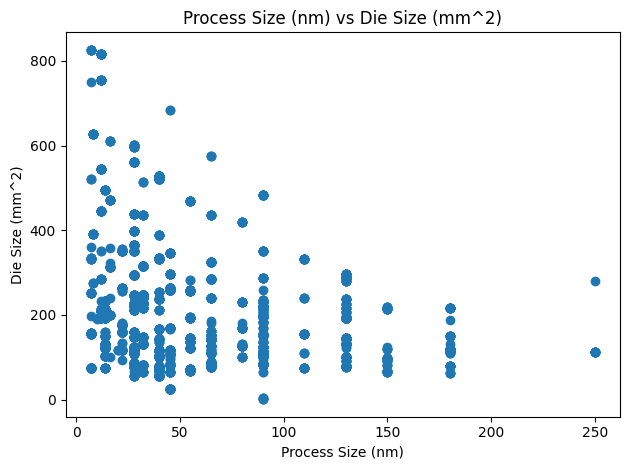

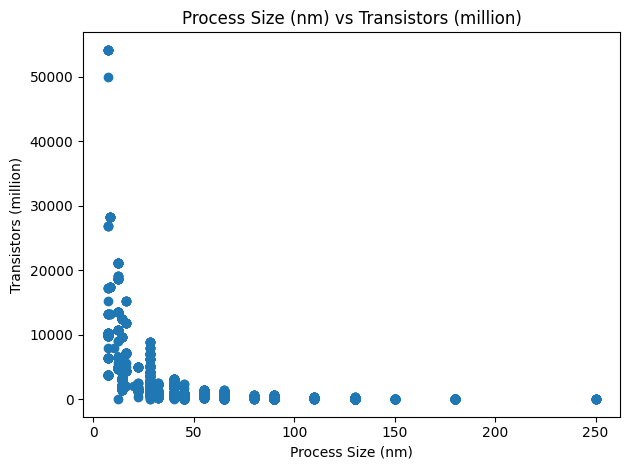

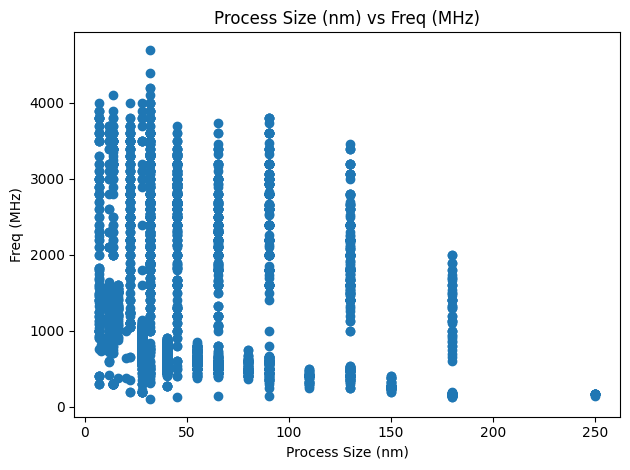

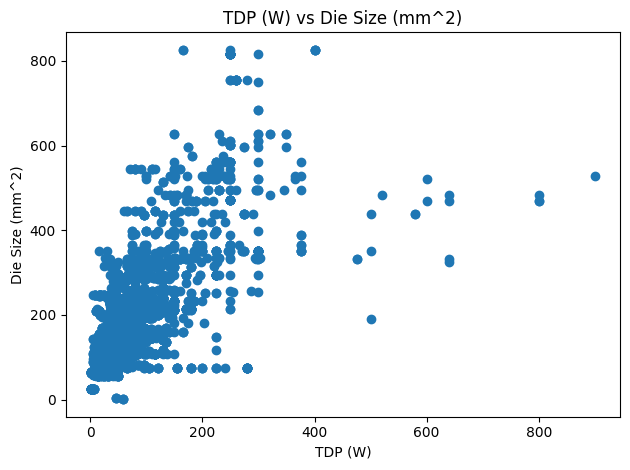

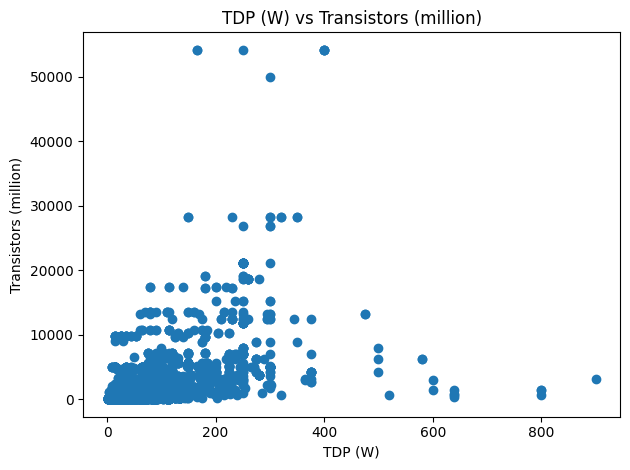

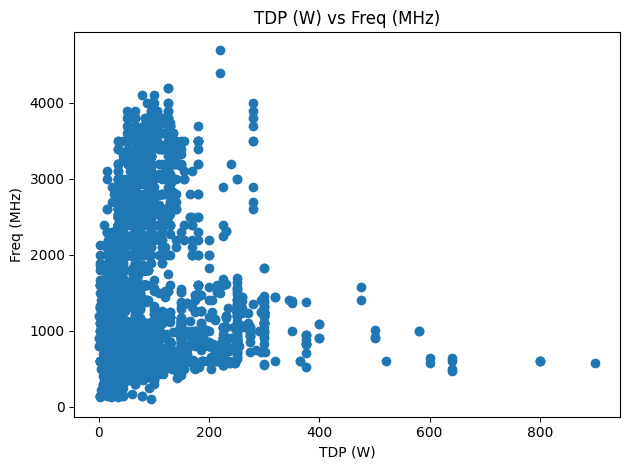

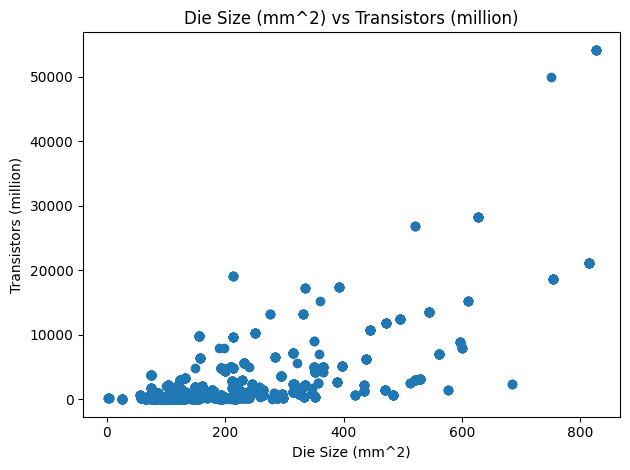

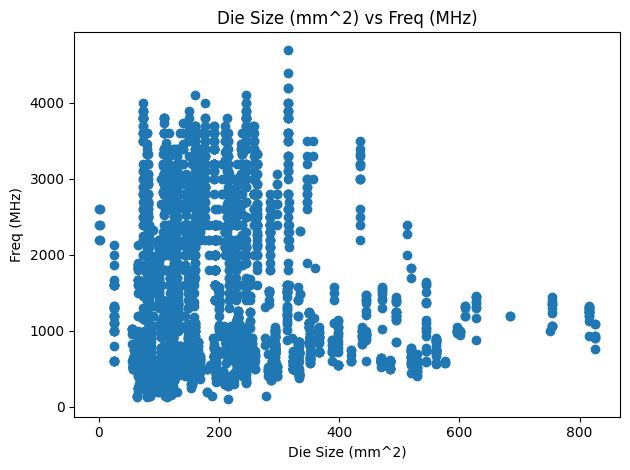

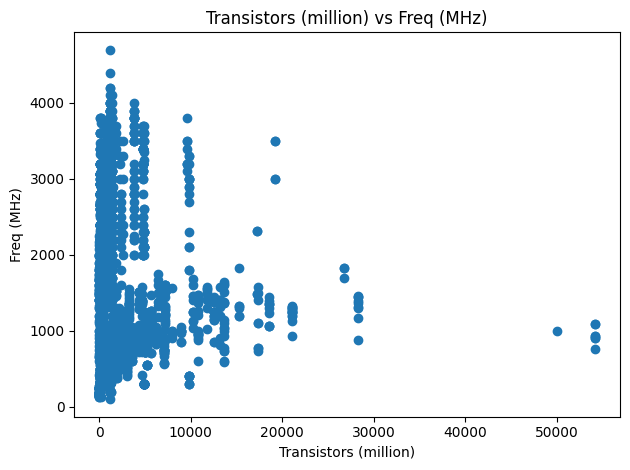

In [55]:
np_df = df.to_numpy()
titles = df.columns
for i in range(np.shape(np_df)[1]):
    for j in range(np.shape(np_df)[1]):
        if i != j and not i>j:
            Title = titles[i]+" vs "+titles[j]
            plt.figure()
            plt.scatter(np_df[:,i],np_df[:,j])
            plt.title(Title);plt.xlabel(titles[i]);plt.ylabel(titles[j])
            plt.tight_layout()
            plt.show()
            plt.close()
#np_df[:,0]

### 2.4 Which range-normalized numerical attributes have the greatest sample covariance? What is their sample covariance? Create a scatter plot of these range-normalized attributes.

[[ 0.02867106 -0.00288473 -0.00599077 -0.00537416 -0.00371555]
 [-0.00288473  0.00766027  0.00942229  0.00328041  0.00121891]
 [-0.00599077  0.00942229  0.02513501  0.00809994 -0.00193181]
 [-0.00537416  0.00328041  0.00809994  0.00636748 -0.00077504]
 [-0.00371555  0.00121891 -0.00193181 -0.00077504  0.04847341]] 
 Max sample covariance: 0.009422291959770054


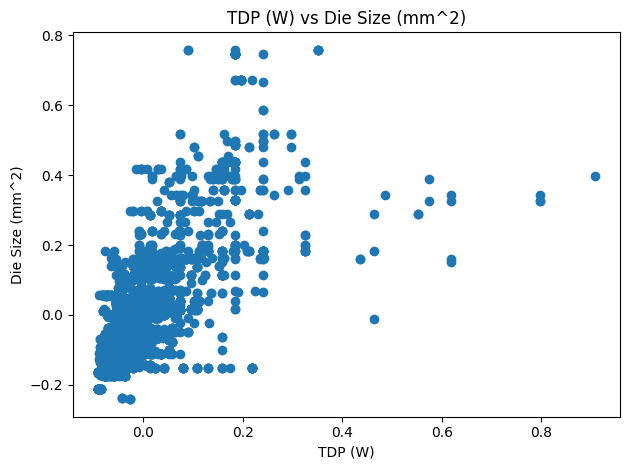

In [56]:
from sklearn.preprocessing import MinMaxScaler
import copy
normalized_df = MinMaxScaler().fit_transform(np_df)
normalized_df = normalized_df - np.mean(normalized_df,axis=0)
cov_matrix = np.cov(normalized_df.T)
cov_only = copy.copy(cov_matrix); np.fill_diagonal(cov_only,0)
max_cov = cov_matrix.flat[np.abs(cov_only).argmax()]
print(cov_matrix,"\n Max sample covariance:",max_cov)
x,y = np.where(abs(cov_matrix) == max_cov)[0]

Title = titles[x]+" vs "+titles[y]
plt.figure()
plt.scatter(normalized_df[:,x],normalized_df[:,y])
plt.title(Title);plt.xlabel(titles[x]);plt.ylabel(titles[y])
plt.tight_layout()
plt.show()
plt.close()

### 2.5 Which Z-score-normalized numerical attributes have the greatest correlation? What is their correlation? Create a scatter plot of these Z-score-normalized attributes.

[[ 0.         -0.19465332 -0.22316236 -0.39774533 -0.09966653]
 [-0.19465332  0.          0.67903941  0.46970179  0.06325548]
 [-0.22316236  0.67903941  0.          0.64026336 -0.05534433]
 [-0.39774533  0.46970179  0.64026336  0.         -0.04411544]
 [-0.09966653  0.06325548 -0.05534433 -0.04411544  0.        ]] 
 Max sample correlation: 0.6790394145082519


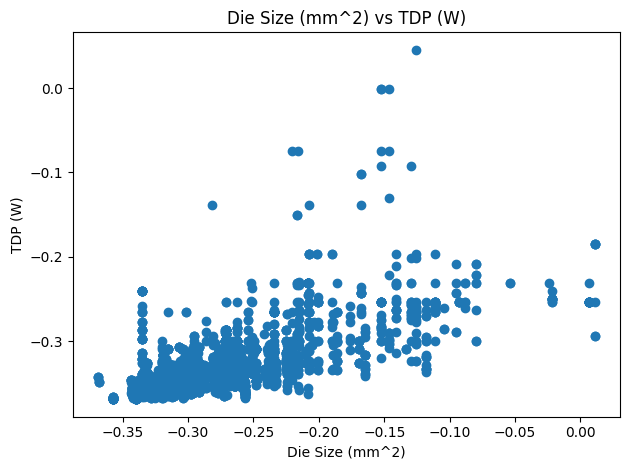

In [57]:
from scipy.stats import zscore
z_df = (np_df-np.mean(np_df))/(np.std(np_df))
corr = np.corrcoef(z_df.T)
np.fill_diagonal(corr,0)
max_corr = corr.flat[np.abs(corr).argmax()]
print(corr,"\n Max sample correlation:",max_corr)
x,y = np.where(abs(corr) == max_corr)
x = x[0]
y = y[0]

Title = titles[x]+" vs "+titles[y]
plt.figure()
plt.scatter(z_df[:,x],z_df[:,y])
plt.title(Title);plt.xlabel(titles[x]);plt.ylabel(titles[y])
plt.tight_layout()
plt.show()
plt.close()

### 2.6 How many pairs of features have correlation greater than or equal to 0.5?

In [58]:
print(int(len(corr[corr>=0.5])/2),"pairs of features have greater than or equal to 0.5 correlation")

2 pairs of features have greater than or equal to 0.5 correlation


### 2.7 How many pairs of features have negative sample covariance?

In [59]:
print(int(len(cov_only[cov_only<0])/2),"pairs of features have negative sample covariance")

6 pairs of features have negative sample covariance


### 2.8 What is the total variance of the data?

In [60]:
print("The total variance of the data is", np.trace(cov_matrix))

The total variance of the data is 0.11630722871961788


### 2.9 What is the total variance of the data, restricted to the five features that have the 3 greatest sample variance?
I took this to mean three features that have 3 greatest sample varience

In [61]:
variances = np.diagonal(cov_matrix)

print("The total varience of the three features that have the greatest sample variance:", sum(sorted(variances,reverse=True)[0:3]))


The total varience of the three features that have the greatest sample variance: 0.10227947745958918


---

## K-Means Clustering
### Computing the Clusters
The code below computes clusters in the data using our custom K-Means Clustering algorithm.

We found that a good number of clusters is 3, as any higher K value tended to produce clusters containing a very low number of points.

Our $\epsilon$ value was also chosen to be 0.001, which dictates the threshold of centroid change that denotes the algorithm should terminate.

The code that performs K-Means Clustering is available in `kmeans.py`.

In [62]:
import kmeans

k = 3

(centroids, assignments) = kmeans.kMeans(df, k, 0.001);
for i, centroid in enumerate(centroids):
    print("Cluster", i, "Centroid:", centroid)

Cluster 0 Centroid: [9.65573770e+00 2.46393443e+02 6.36672131e+02 2.54393443e+04
 1.40159016e+03]
Cluster 1 Centroid: [  15.725       148.31538462  295.26153846 6779.20769231 1531.84423077]
Cluster 2 Centroid: [  60.81168603   68.42907427  173.19253784  818.65857093 1505.87785991]


### Plotting the Clusters
Below is an example plot of our clustering. The colors of each point correspond to their assigned cluster.

Cluster centroids are denoted by the larger black points.

Changing the `xAxis` and `yAxis` values to any integer between 0 and 4 will change which two features are compared.

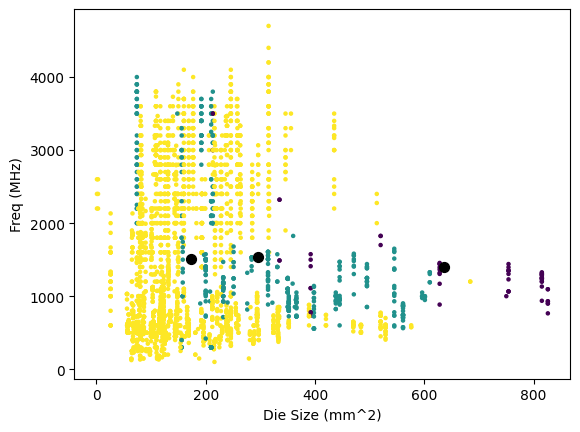

In [63]:
import matplotlib.pyplot as plt

xAxis = 2
yAxis = 4

plt.scatter(df.values[:,xAxis], df.values[:,yAxis], c=assignments, s=5)
plt.scatter(centroids[:,xAxis], centroids[:,yAxis], c='black', s=50)
plt.xlabel(df.columns[xAxis])
plt.ylabel(df.columns[yAxis]);

## DBScan Based Clustering

In [64]:
import dbscan

dbScanAlg = dbscan.DBScan(40, 0.6, -3)
# dbscan works a bit better with normalized data
normalizedDF = (df-df.mean())/df.std()
(assignments, corePts, borderPts, noisePts) = dbScanAlg.runAlgorithm(normalizedDF);
for i in assignments:
    print(i)

1
4
1
1
1
1
1
2
3
1
1
1
2
1
2
-3
1
2
2
-3
-3
2
3
1
-3
1
1
-3
1
1
1
2
-3
1
1
4
1
-3
1
1
-3
1
2
1
1
-3
-3
-3
2
3
3
1
2
1
-3
1
2
1
-3
1
-3
1
1
1
1
1
3
3
1
1
1
1
3
2
2
1
1
1
1
1
1
-3
3
1
1
3
2
1
-3
-3
1
1
1
4
1
1
-3
2
1
3
3
-3
2
1
1
1
1
1
3
1
-3
4
-3
1
-3
3
4
4
1
1
1
1
1
1
1
-3
1
2
3
-3
1
1
3
1
-3
-3
1
-3
1
1
-3
1
1
1
1
1
1
1
1
1
1
2
3
1
2
-3
3
1
1
1
1
-3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
3
1
1
1
1
1
1
-3
1
1
1
1
3
4
1
-3
2
-3
1
1
3
7
-3
3
1
1
-3
-3
1
1
1
2
1
-3
1
-3
1
2
1
1
1
1
2
2
3
-3
1
1
1
4
3
-3
1
1
1
4
2
1
1
1
1
1
2
1
1
-3
3
2
1
2
1
3
1
1
1
2
3
-3
1
1
1
1
-3
1
-3
1
1
1
1
-3
1
1
1
-3
1
1
1
1
3
1
1
-3
1
1
2
2
1
-3
-3
3
3
1
1
1
1
-3
1
1
-3
1
1
3
3
3
2
3
1
1
3
4
3
-3
1
-3
1
-3
3
-3
3
1
1
-3
1
2
3
1
1
4
2
-3
1
1
-3
1
1
3
1
-3
-3
1
1
3
1
2
3
1
3
3
-3
-3
1
1
1
4
-3
1
-3
1
1
3
2
1
1
-3
3
-3
3
1
1
-3
1
-3
2
2
1
1
2
3
1
3
2
1
1
3
1
1
1
1
1
1
1
1
1
1
4
3
3
1
1
1
1
-3
-3
1
1
-3
1
-3
1
3
1
2
2
3
4
1
1
3
-3
1
3
1
3
-3
1
1
1
2
1
2
-3
1
1
3
-3
2
3
1
-3
1
2
-3
1
1
3
2
-3
1
-3
3
1
1
1
1
-3
1
1
-3
1
2
-3
-

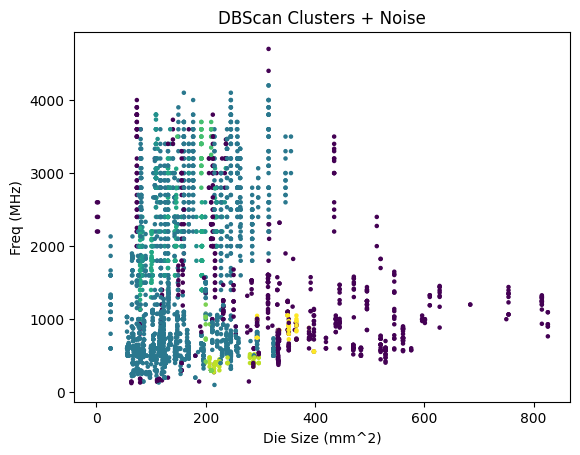

In [65]:
xAxis = 2
yAxis = 4

plt.scatter(df.values[:,xAxis], df.values[:,yAxis], c=assignments, s=5)
plt.title("DBScan Clusters + Noise")
plt.xlabel(df.columns[xAxis])
plt.ylabel(df.columns[yAxis]);

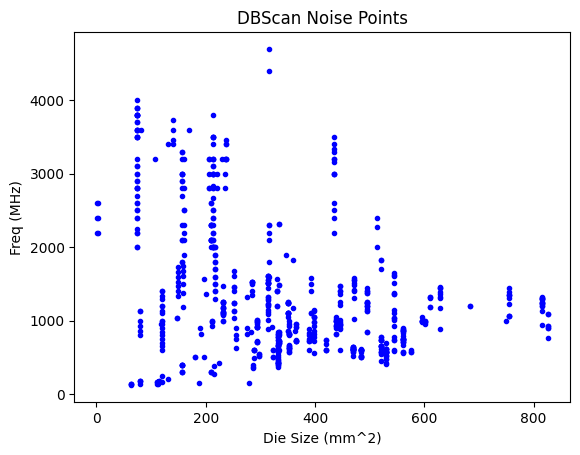

In [66]:
for i in noisePts:
    plt.plot(df.values[i,xAxis], df.values[i,yAxis], marker="o", markerfacecolor='blue', markersize=3, markeredgecolor='blue')

plt.title("DBScan Noise Points")
plt.xlabel(df.columns[xAxis])
plt.ylabel(df.columns[yAxis]);

## 4.1 PCA graph in 2dim 

data is scaled b/c different units, two pca's are fit (one for 2Dim, one for no specified dim)

In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler(with_std=True,
                        with_mean=True)
df_scaled = scaler.fit_transform(df)

pcadf = PCA() #unspecified number of components
pcadf2 = PCA(n_components=2) #2 components
pcadf.fit(df_scaled)
pcadf2.fit(df_scaled)
pcadf2.mean_

array([ 3.32223371e-17, -7.47502586e-17,  8.30558429e-17,  0.00000000e+00,
        0.00000000e+00])

In [68]:
scores = pcadf2.transform(df_scaled)
pcadf2.components_

array([[-0.3280872 ,  0.5204522 ,  0.57017362,  0.54436719,  0.00739614],
       [ 0.41993748,  0.0383736 ,  0.17551634,  0.04464073, -0.88847127]])

Graph of 2D pca,

"Does it look like there are clusters
in these two dimensions? If so, how many would you say there are?"

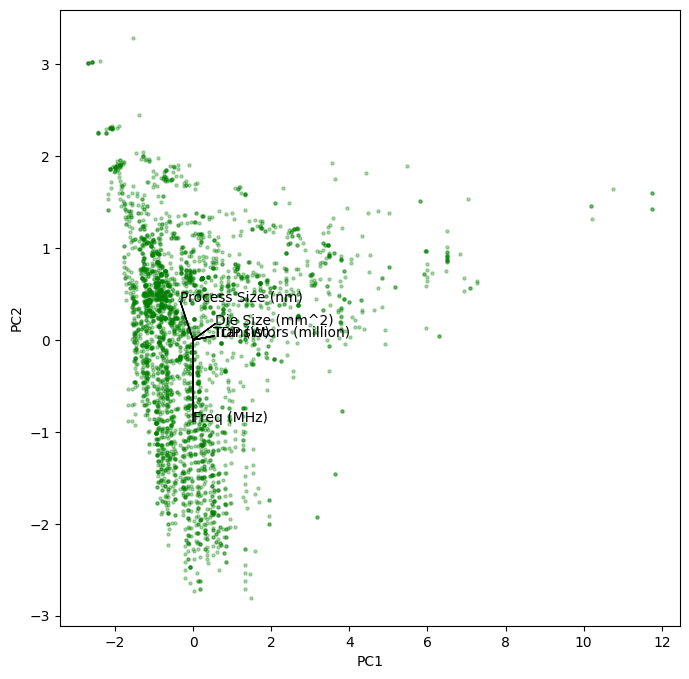

In [69]:
i, j = 0, 1 # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:,0], scores[:,1], s=5, color='green', alpha=0.3)
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pcadf2.components_.shape[1]):
    ax.arrow(0, 0, pcadf2.components_[i,k], pcadf2.components_[j,k],)
    ax.text(pcadf2.components_[i,k],
    pcadf2.components_[j,k],
    df.columns[k],)

Same graph but scaling arrows and text for readability, 
graph flipped for perspective reasons but re-running will invert to normal

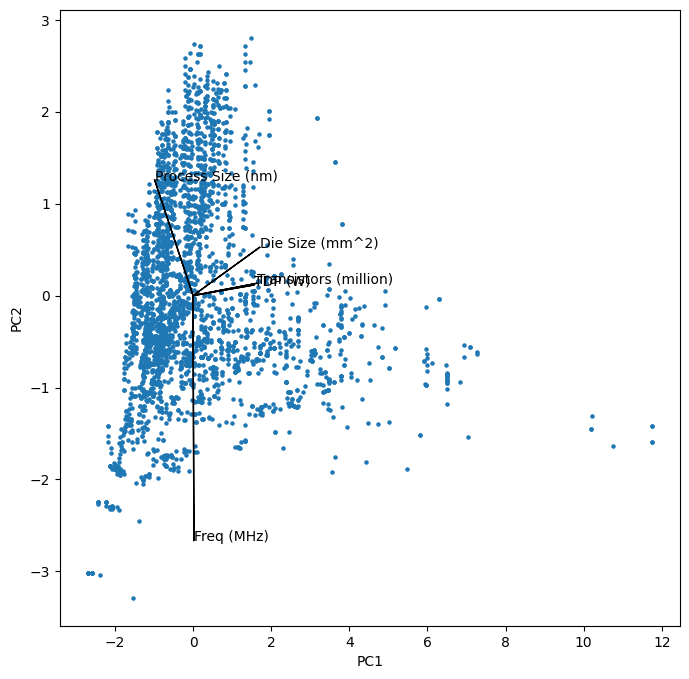

In [70]:
scale_arrow = s_ = 3
scores[:,1] *= -1
pcadf.components_[1] *= -1 # flip the y-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:,0], scores[:,1], s=5)
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pcadf2.components_.shape[1]):
    ax.arrow(0, 0, s_*pcadf2.components_[i,k], s_*pcadf2.components_[
        j,k])
    ax.text(s_*pcadf2.components_[i,k],
            s_*pcadf2.components_[j,k],
            df.columns[k])

In [71]:
scores.std(0, ddof=1)

array([1.53606378, 1.02851077])

explained variance and ratio for our two component pca

In [72]:
pcadf2.explained_variance_

array([2.35949195, 1.0578344 ])

In [73]:
pcadf2.explained_variance_ratio_

array([0.47176049, 0.21150505])

## 4.2 PCA unspecified components graphs

graphs for 4.2

"Based on this plot, choose a number of principal components to reduce the dimensionality of the data. Report how many principal components will be used as well as the faction of total variance captured using this many components."

Based on graphs we'd want 4, yadda yadda flesh out later

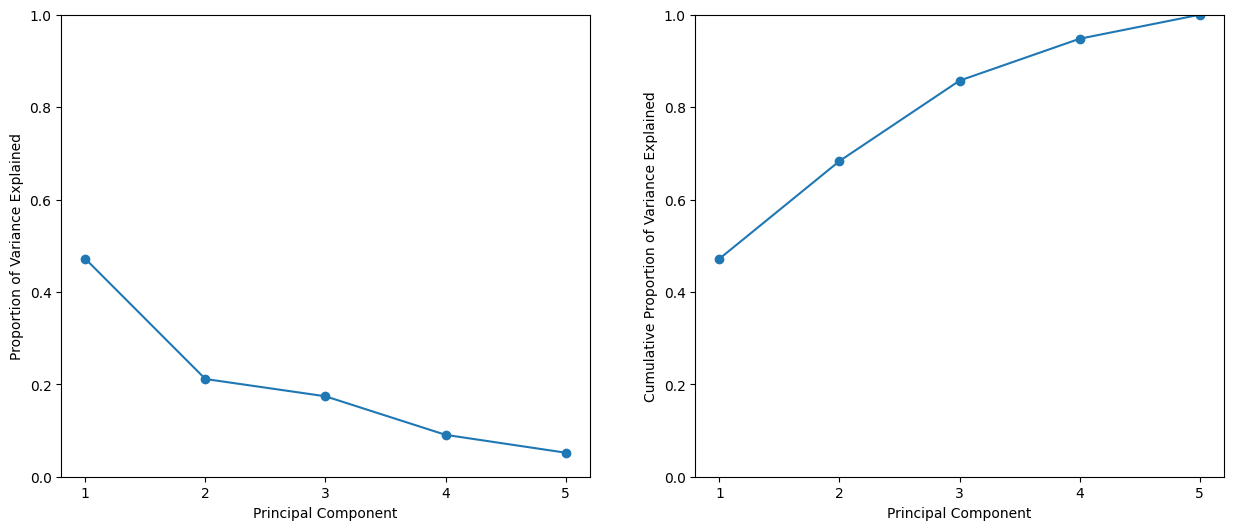

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ticks = np.arange(pcadf.n_components_)+1
ax = axes[0]
ax.plot(ticks,
    pcadf.explained_variance_ratio_,
    marker='o')
ax.set_xlabel('Principal Component');
ax.set_ylabel('Proportion of Variance Explained')
ax.set_ylim([0,1])
ax.set_xticks(ticks)
ax = axes[1]
ax.plot(ticks,
    pcadf.explained_variance_ratio_.cumsum(),
    marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion of Variance Explained')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)


In [75]:
pcadf.explained_variance_

array([2.35949195, 1.0578344 , 0.87065394, 0.45344625, 0.26003502])

In [76]:
pcadf.explained_variance_ratio_

array([0.47176049, 0.21150505, 0.1740799 , 0.09066275, 0.05199181])

## 4.3

run a k-means analysis (use our own + sickit) for 4.3 and a DBSCAN analysis for 
4.4